In [83]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import pywt
import pandas as pd
import scipy.stats as stats

from scipy.io import loadmat

from sklearn.decomposition import PCA
from sklearn.decomposition import NMF
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from matplotlib import pyplot as plt

## Summary of the following notebook : 

### Task 0
Preprocessing of the data according to the exercise session 2 (exercise_session2.ipynb).

### Task 1
Extract features of the signal acquired from different subjects. Analyze it and try to depict some patterns/regularity. 

### Task 2
Run different classifier models across all the subjects. Split the data from one subject into a 2 distincts datasets : train and test. Then perform the model on it.
We can search which coefficient in the model contributes the most and then rank the relevance of each features.

### Task 3
Find couples that share similar features, so that the classification model training can be done on the first subject and the testing on the other.

### Task 4
The model is trained on a subset of n subjects and evaluated on another subset, increasing n progressively according to the results obtained.

# TASK 0 : load the data

In [84]:
# load the data
n_subj = 27

emg_data_E1={}
stimulus_E1={}
repetition_E1={}

for i in range(n_subj):
    data_E1 = loadmat("data/S%d_A1_E1.mat"%(i+1))
    emg_data_E1[i] = data_E1["emg"]
    stimulus_E1[i] = data_E1["stimulus"]
    repetition_E1[i] = data_E1["repetition"]

In [85]:
# store sizes
n_channels = emg_data_E1[0].shape[1]
n_stimuli = int(np.unique(stimulus_E1[0]).size - 1)  # remove rest
n_repetitions = int(np.unique(repetition_E1[0]).size - 1)  # remove rest

n_epochs = n_stimuli * n_repetitions
n_tsteps = 500 #because of subject 13

In [86]:
emg_tensor_E1 = np.zeros((n_subj, n_stimuli, n_repetitions, n_tsteps, n_channels))
for n in range(n_subj):
    for i in range(n_stimuli):
        for j in range(n_repetitions):
            sel = np.squeeze(np.logical_and(stimulus_E1[n] == (i + 1), repetition_E1[n] == (j + 1)))
            emg_selected_data = emg_data_E1[n][sel, :]
            emg_tensor_E1[n, i, j, :, :] = emg_selected_data[:n_tsteps, :]

In [87]:
emg_tensor_E1.shape

(27, 12, 10, 500, 10)

### Feature Extraction

In [88]:
# Example of features
def features_estimation(signal, fs):
    """
    Compute time, frequency and time-frequency features from signal.
    :param signal: numpy array signal.
    :param channel_name: string variable with the EMG channel name in analysis.
    :param fs: int variable with the sampling frequency used to acquire the signal
    :return: total_feature_matrix -- python list
    :return: features_names -- python list with
    """

    features_names = ['VAR', 'RMS', 'IEMG', 'MAV', 'LOG', 'WL', 'ACC', 'DASDV', 'ZC', 'WAMP', 'MYOP', "MNP", "TP",
                      "MNF", "MDF", "PKF", "WENT"]

    time_matrix = time_features_estimation(signal)
    frequency_matrix = frequency_features_estimation(signal, fs)
    time_frequency_matrix = time_frequency_features_estimation(signal)
    total_feature_matrix = np.column_stack((time_matrix, frequency_matrix, time_frequency_matrix))

    return total_feature_matrix


def time_features_estimation(signal):
    """
    Compute time features from signal
    :param signal: numpy array signal.
    """

    th = np.mean(signal) + 3 * np.std(signal)

    variance = (np.var(signal))
    rms = (np.sqrt(np.mean(signal ** 2)))
    iemg = (np.sum(abs(signal)))  # Integral
    mav = (np.sum(np.absolute(signal)) / len(signal))  # Mean Absolute Value
    log_detector = (np.exp(np.sum(np.log10(np.absolute(signal))) / len(signal)))
    wl = (np.sum(abs(np.diff(signal))))  # Wavelength
    aac = (np.sum(abs(np.diff(signal))) / len(signal))  # Average Amplitude Change
    dasdv = (math.sqrt((1 / (len(signal) - 1)) * np.sum((np.diff(signal)) ** 2)))  # Difference absolute standard deviation value
    zc = (zcruce(signal, th))  # Zero-Crossing
    wamp = (wilson_amplitude(signal, th))  # Willison amplitude
    myop = (myopulse(signal, th))  # Myopulse percentage rate

    time_features_matrix = np.column_stack((variance, rms, iemg, mav, log_detector, wl, aac, dasdv, zc, wamp, myop))
    return time_features_matrix


def frequency_features_estimation(signal, fs):
    """
    Compute frequency features from signal
    :param signal: numpy array signal.
    :param fs: sampling frequency of the signal.
    :return: frequency_features_matrix: narray matrix with the frequency features stacked by columns.
    """

    frequency, power = spectrum(signal, fs)
    
    mnp = (np.sum(power) / len(power))  # Mean power
    tot = (np.sum(power))  # Total power
    mnf = (mean_freq(frequency, power))  # Mean frequency
    mdf = (median_freq(frequency, power))  # Median frequency
    pkf = (frequency[power.argmax()])  # Peak frequency

    frequency_features_matrix = np.column_stack((mnp, tot, mnf, mdf, pkf))

    return frequency_features_matrix


def time_frequency_features_estimation(signal):
    """
    Compute time-frequency features from signal
    :param signal: numpy array signal.
    :return: h_wavelet: list
    """
    h_wavelet = []

    E_a, E = wavelet_energy(signal, 'db2', 4)
    E.insert(0, E_a)
    E = np.asarray(E) / 100

    h_wavelet.append(-np.sum(E * np.log2(E)))

    return h_wavelet


def wilson_amplitude(signal, th):
    x = abs(np.diff(signal))
    umbral = x >= th
    return np.sum(umbral)


def myopulse(signal, th):
    umbral = signal >= th
    return np.sum(umbral) / len(signal)


def spectrum(signal, fs):
    m = len(signal)
    n = next_power_of_2(m)
    y = np.fft.fft(signal, n)
    yh = y[0:int(n / 2 - 1)]
    fh = (fs / n) * np.arange(0, n / 2 - 1, 1)
    power = np.real(yh * np.conj(yh) / n)

    return fh, power

def shannon(x):
    N = len(x)
    nb = 19
    hist, bin_edges = np.histogram(x, bins=nb)
    counts = hist / N
    nz = np.nonzero(counts)

    return np.sum(counts[nz] * np.log(counts[nz]) / np.log(2))


def zcruce(X, th):
    th = 0
    cruce = 0
    for cont in range(len(X) - 1):
        can = X[cont] * X[cont + 1]
        can2 = abs(X[cont] - X[cont + 1])
        if can < 0 and can2 > th:
            cruce = cruce + 1
    return cruce


def mean_freq(frequency, power):
    num = 0
    den = 0
    for i in range(int(len(power) / 2)):
        num += frequency[i] * power[i]
        den += power[i]

    return num / den


def median_freq(frequency, power):
    power_total = np.sum(power) / 2
    temp = 0
    tol = 0.01
    errel = 1
    i = 0

    while abs(errel) > tol:
        temp += power[i]
        errel = (power_total - temp) / power_total
        i += 1
        if errel < 0:
            errel = 0
            i -= 1

    return frequency[i]


def wavelet_energy(x, mother, nivel):
    coeffs = pywt.wavedecn(x, wavelet=mother, level=nivel)
    arr, _ = pywt.coeffs_to_array(coeffs)
    Et = np.sum(arr ** 2)
    cA = coeffs[0]
    Ea = 100 * np.sum(cA ** 2) / Et
    Ed = []

    for k in range(1, len(coeffs)):
        cD = list(coeffs[k].values())
        cD = np.asarray(cD)
        Ed.append(100 * np.sum(cD ** 2) / Et)

    return Ea, Ed


def next_power_of_2(x):
    return 1 if x == 0 else 2 ** (x - 1).bit_length()


def med_freq(f, P):
    Ptot = np.sum(P) / 2
    temp = 0
    tol = 0.01
    errel = 1
    i = 0

    while abs(errel) > tol:
        temp += P[i]
        errel = (Ptot - temp) / Ptot
        i += 1
        if errel < 0:
            errel = 0
            i -= 1

    return f[i]

In [89]:
fs = 100 # set frequency
out = features_estimation(signal=emg_tensor_E1[0, 0, 0, :, 1], fs=100)
out.shape

(1, 17)

In [90]:
print("n_stimuli : ", n_stimuli)
print("n_repetitions : ", n_repetitions)
print("n_channels : ", n_channels)

n_stimuli :  12
n_repetitions :  10
n_channels :  10


In [91]:
# extract all the features with using features_estimation
emg_features = {}
labels_dict = {}
for n in range(n_subj):
    all_feature_list = []
    labels = []
    for i in range(n_stimuli):
        for j in range(n_repetitions):
            channelwise_feature_list = []
            for k in range(n_channels):
                current_channel_features = features_estimation(signal=emg_tensor_E1[n, i, j, :, k], fs=fs)
                channelwise_feature_list.append(current_channel_features)
            channelwise_features = np.hstack(channelwise_feature_list)
            all_feature_list.append(channelwise_features)
            labels.append(i)
            
    # store for each subject
    emg_features[n] = np.vstack(all_feature_list)
    labels_dict[n] = np.array(labels)

C:\Users\maxim\AppData\Local\Temp\ipykernel_18092\3696181045.py:35: RuntimeWarning: divide by zero encountered in log10
  log_detector = (np.exp(np.sum(np.log10(np.absolute(signal))) / len(signal)))


In [92]:
feature_names = [
    "VAR", "RMS", "IEMG", "MAV", "LOG", 
    "WL", "ACC", "DASDV", "ZC", "WAMP", 
    "MYOP", "MNP", "TP", "MNF", "MDF",
    "PKF", "WENT"
]
n_features_per_channel = len(feature_names)

<AxesSubplot: >

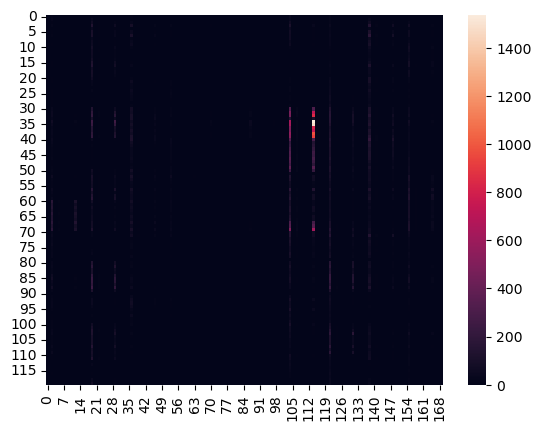

In [93]:
# check for meaningless features
fig, ax = plt.subplots()
sns.heatmap(data=emg_features[0])

<AxesSubplot: >

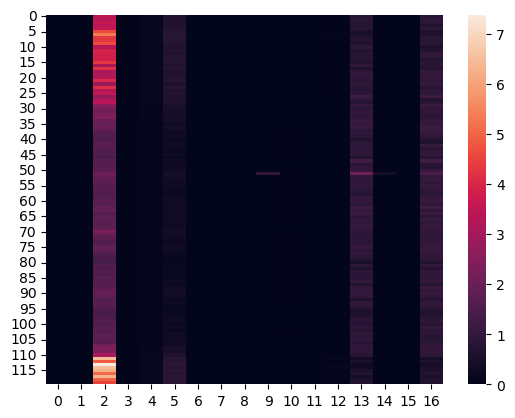

In [94]:
fig, ax = plt.subplots()
sns.heatmap(data=emg_features[10][:, :n_features_per_channel], ax=ax)

In [95]:
np.expand_dims(np.min(emg_features, axis=0), axis=0).shape

(1,)

C:\Users\maxim\AppData\Local\Temp\ipykernel_18092\3145188324.py:7: RuntimeWarning: invalid value encountered in divide
  emg_minmax = (emg_features[n] - emg_mins) / (emg_maxs - emg_mins)


<AxesSubplot: >

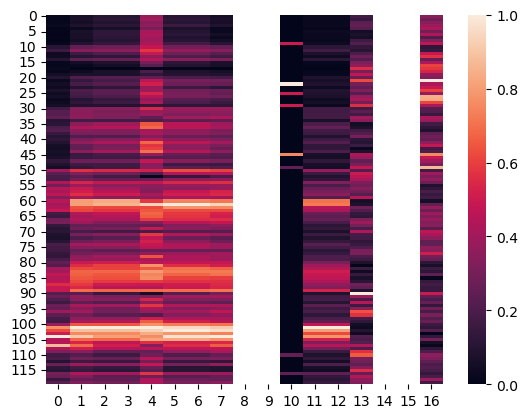

In [96]:
n=1
emg_mins = np.expand_dims(np.min(emg_features[n], axis=0), axis=0)
emg_maxs = np.expand_dims(np.max(emg_features[n], axis=0), axis=0)
emg_mins = np.tile(emg_mins, [emg_features[n].shape[0], 1])
emg_maxs = np.tile(emg_maxs, [emg_features[n].shape[0], 1])

emg_minmax = (emg_features[n] - emg_mins) / (emg_maxs - emg_mins)
fig, ax = plt.subplots()
sns.heatmap(emg_minmax[:, :n_features_per_channel], ax=ax)

In [97]:
emg_features[0].shape

(120, 170)

Features 8, 9 and 15 are meaningless. Feature 14 is meaningfull for some subject, we will keep it.

C:\Users\maxim\AppData\Local\Temp\ipykernel_18092\3989994414.py:16: RuntimeWarning: invalid value encountered in divide
  emg_minmax = (emg_features_ok[n] - emg_mins) / (emg_maxs - emg_mins)


<AxesSubplot: >

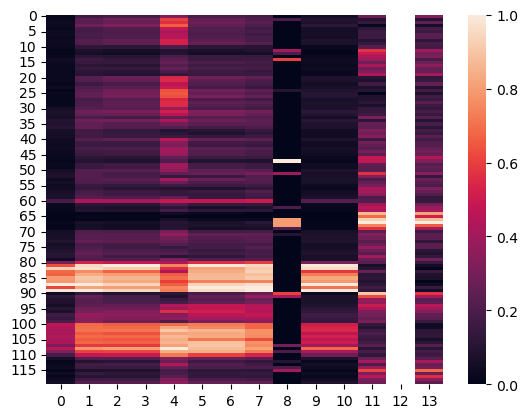

In [98]:
# feature 8, 9, 15 are meaningless for these data
feature_8 = np.arange(start=8, stop=170, step=17)
feature_9 = np.arange(start=9, stop=170, step=17)
feature_15 = np.arange(start=15, stop=170, step=17)
bad_cols = np.hstack((feature_8, feature_9, feature_15))
emg_features_ok = {}
for n in range(n_subj):
    emg_features_ok[n] = np.delete(emg_features[n], bad_cols, 1)

n=20
emg_mins = np.expand_dims(np.min(emg_features_ok[n], axis=0), axis=0)
emg_maxs = np.expand_dims(np.max(emg_features_ok[n], axis=0), axis=0)
emg_mins = np.tile(emg_mins, [emg_features_ok[n].shape[0], 1])
emg_maxs = np.tile(emg_maxs, [emg_features_ok[n].shape[0], 1])

emg_minmax = (emg_features_ok[n] - emg_mins) / (emg_maxs - emg_mins)
fig, ax = plt.subplots()
sns.heatmap(emg_minmax[:, :(n_features_per_channel - 3)], ax=ax)

In [99]:
emg_features_ok[2].shape

(120, 140)

In [100]:
feature_names = [
    "VAR", "RMS", "IEMG", "MAV", "LOG", "WL", 
    "ACC", "DASDV", "MYOP", "MNP", "TP", 
    "MNF", "PKF", "WENT"]

### Normalize the data

In [101]:
from scipy.stats import zscore

In [102]:
emg_features_norm = {}
for n in range(n_subj):
    emg_features_norm[n] = zscore(emg_features_ok[n], axis=1)

## Reshape the data 

In [103]:
labels_dict[5].shape

(120,)

In [104]:
# create n_subj dictionnnaray 
df_dict={}

for n in range(n_subj):
    # each one contains n_repetitions of the task
    df_dict[n]={}
    for k in range(n_repetitions):
        df_dict[n][k] = pd.DataFrame(emg_features_norm[n][:,(k*14):14*(k+1)], columns=feature_names)
        df_dict[n][k]['label']=labels_dict[n]


In [105]:
df_dict[1][9].head(15)

,VAR,RMS,IEMG,MAV,LOG,WL,ACC,DASDV,MYOP,MNP,TP,MNF,PKF,WENT,label
0,-0.287188,-0.284779,0.544863,-0.285616,-0.281138,-0.224311,-0.287154,-0.287061,-0.286677,-0.287047,-0.227875,-0.277045,-0.287280,-0.277788,0
1,-0.266374,-0.264920,0.239520,-0.265409,-0.262311,-0.224915,-0.266337,-0.266279,-0.266420,-0.266299,-0.235525,-0.258024,-0.266420,-0.257984,0
2,-0.285193,-0.282392,0.700402,-0.283430,-0.280709,-0.220524,-0.285272,-0.285173,-0.285402,-0.284894,-0.156057,-0.280003,-0.285402,-0.280819,0
3,-0.292090,-0.288990,0.769558,-0.290323,-0.288490,-0.237075,-0.292336,-0.292250,-0.292447,-0.291677,-0.096222,-0.288880,-0.292447,-0.290862,0
4,-0.279794,-0.277705,0.478398,-0.278377,-0.275162,-0.224949,-0.279784,-0.279713,-0.279894,-0.279616,-0.209068,-0.274413,-0.279894,-0.275359,0
5,-0.292787,-0.290126,0.732455,-0.290920,-0.287849,-0.235020,-0.292855,-0.292793,-0.292970,-0.292404,-0.148556,-0.289901,-0.292970,-0.290490,0
6,-0.291487,-0.288612,0.760215,-0.289635,-0.287148,-0.234339,-0.291624,-0.291552,-0.291738,-0.291089,-0.126174,-0.288380,-0.291738,-0.288892,0
7,-0.295774,-0.292300,1.091731,-0.293325,-0.290853,-0.221391,-0.295951,-0.295877,-0.296101,-0.295058,-0.030093,-0.293422,-0.296101,-0.293940,0
8,-0.289841,-0.286850,0.933023,-0.287611,-0.284625,-0.212355,-0.289902,-0.289822,-0.290057,-0.289263,-0.087412,-0.286575,-0.290057,-0.286457,0
9,-0.292344,-0.289722,0.670918,-0.290643,-0.288114,-0.232823,-0.292450,-0.292388,-0.292570,-0.291980,-0.142139,-0.289448,-0.292570,-0.290209,0


# Task 1. 
***Extract the same set of features from the signals acquired from different subjects. Look at the typical values of such features across the same set of movements for different subjects. Do you see any regularity?***

### Variation of the features for the same subject but on different repetitions.

### Distribution

In [106]:
# set the value of the choosen stimuli
S=11

# number of features 
n_features = len(feature_names)

# choose the 2 pateints to compare 
N1 = 0  # male right handed 
N2 = 10  # left handed female

# feature names 
names = feature_names

# select the 2 sub-dataframes to compare
df_1 = df_dict[N1][0][df_dict[N1][0]['label']==S]
df_2 = df_dict[N2][0][df_dict[N2][0]['label']==S]
print(df_1.shape)

# stack all the repetitions together
for k in range(1, n_repetitions):
    df_1 = pd.concat([df_1, df_dict[N1][k][df_dict[N1][k]['label']==S]], axis = 0, ignore_index=True)
    df_2 = pd.concat([df_2, df_dict[N2][k][df_dict[N2][k]['label']==S]], axis = 0, ignore_index=True)

(10, 15)


DISTRIBUTION OF EACH FEATURES : patient 0 VS patient 10


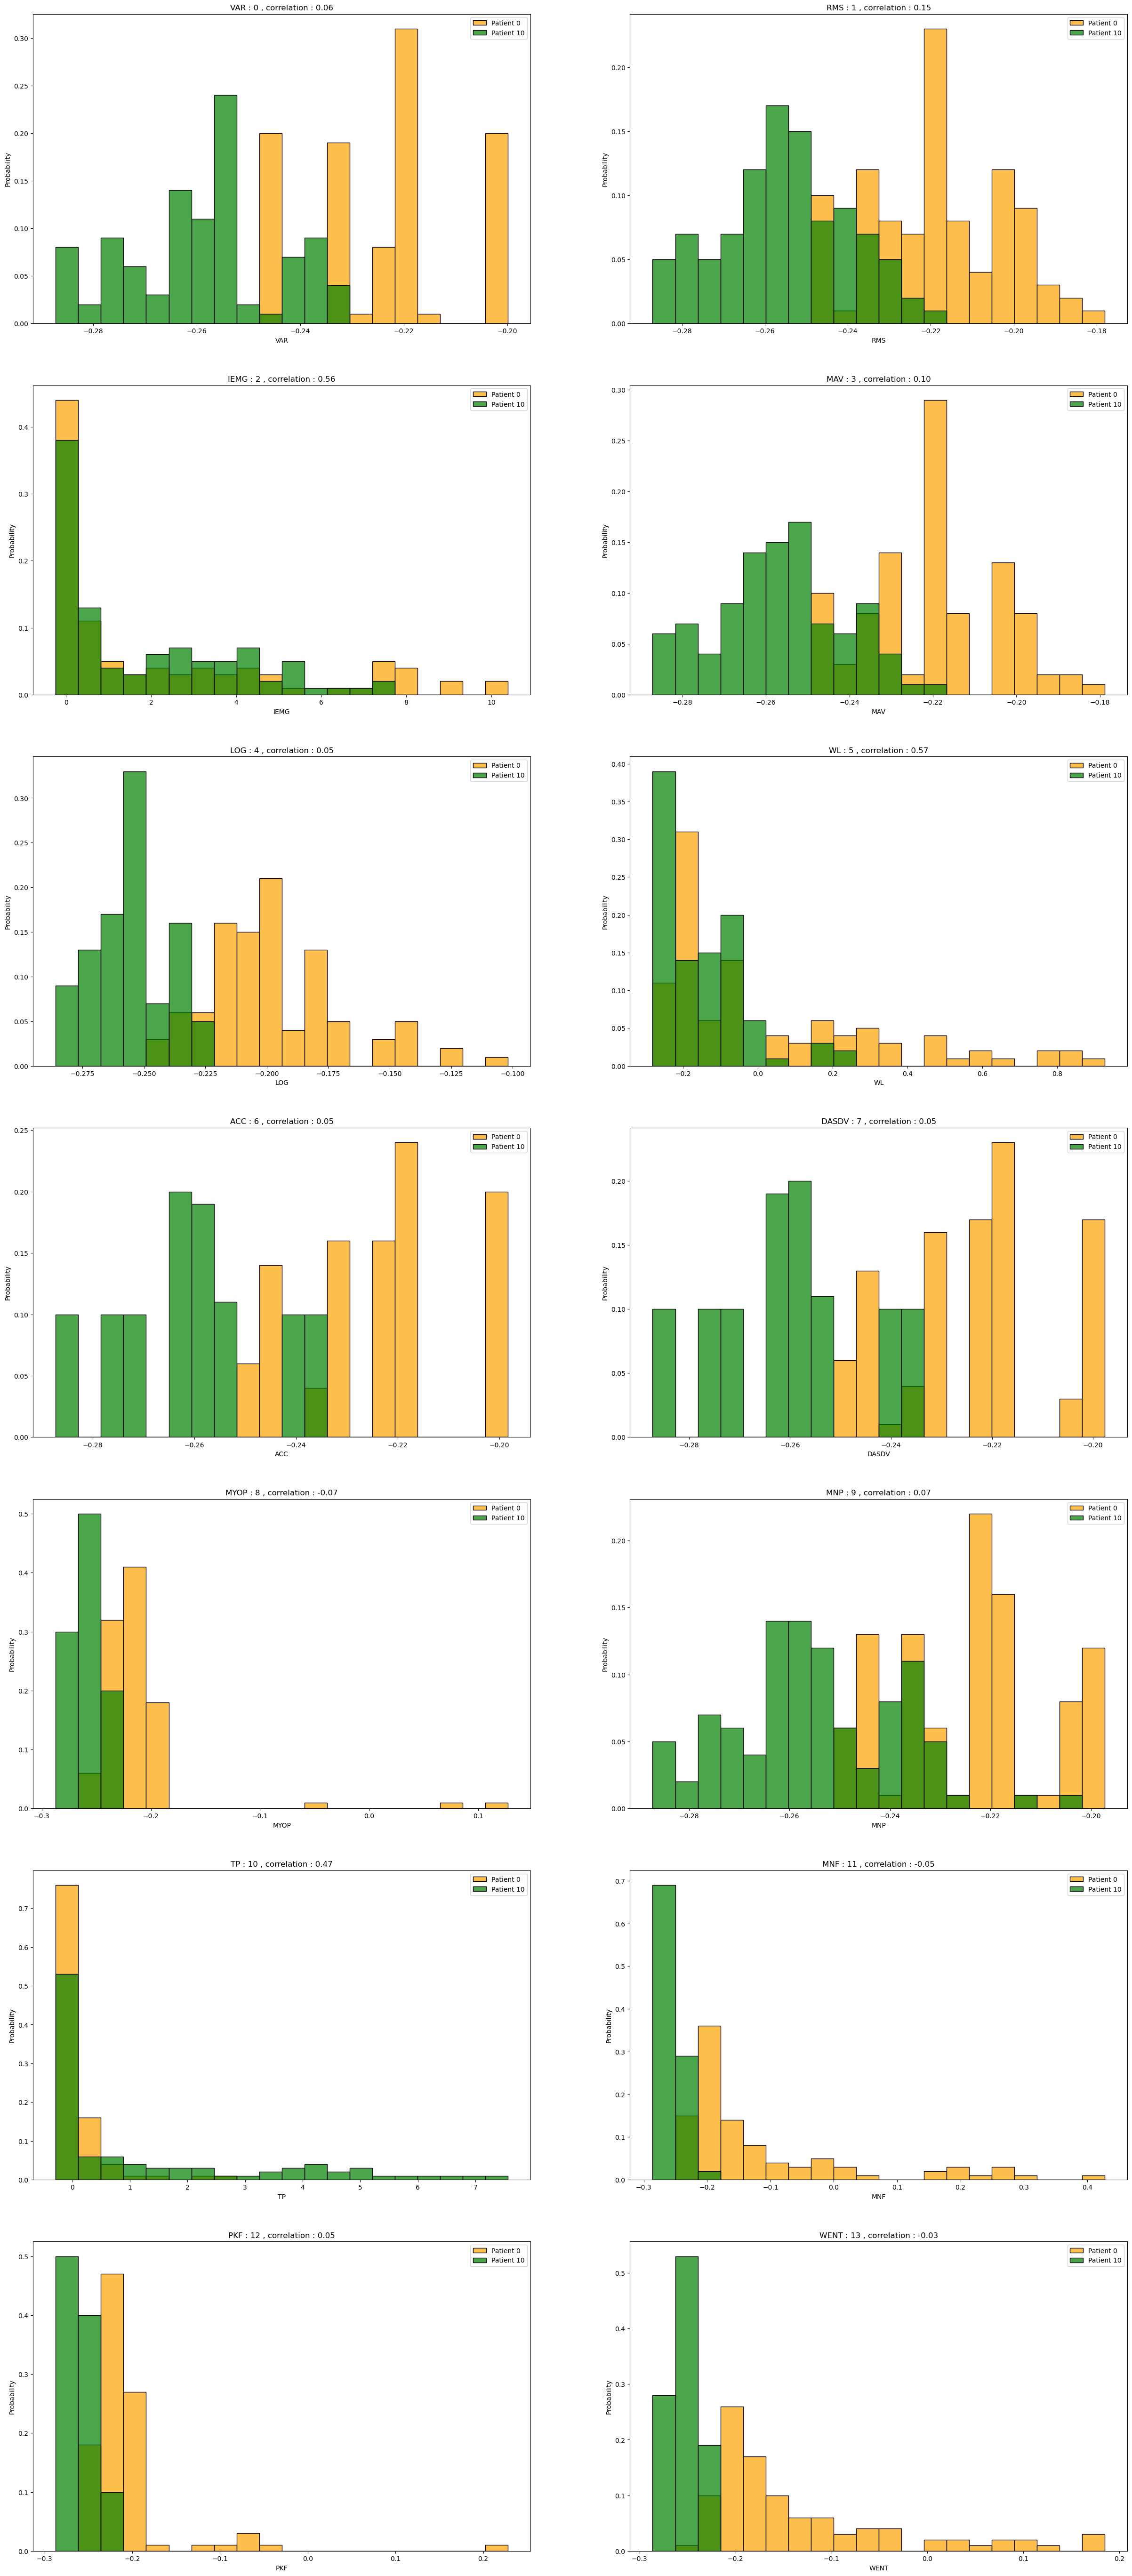

In [107]:
print("DISTRIBUTION OF EACH FEATURES : patient {0:d} VS patient {1:d}".format(N1, N2))
plt.figure(figsize=(30, 10*np.int32(np.ceil(n_features/2))))
for i in range(n_features):
        plt.subplot(np.int32(np.ceil(n_features/2)), 2, i+1)
        
        #binwidth=(np.max(x0)-np.min(x0))/20
        
        x0 = df_1.iloc[:,i]
        x1 = df_2.iloc[:,i]
        
        bins=20
        bins = np.histogram(np.hstack((x0, x1)), bins=bins)[1]
        ax0 = sns.histplot(x0, stat='probability', bins=bins, color='orange', alpha=0.7, label='Patient {0:d}'.format(N1))
        ax1 = sns.histplot(x1, stat='probability', bins=bins, color='green', alpha=0.7, label='Patient {0:d}'.format(N2))
        
        plt.title("{0:s} : {1:d} , correlation : {2:.2f}".format(names[i], i, np.corrcoef(x0, x1)[0,1]))
        plt.legend()
        

Here we can observe large difference between patients 0 and patient 13. For some features like IEMG (2) and TP (10), distribution looks the same but for the other features, it looks to be be very different.

### Correlation matrix

In [108]:
import random

In [109]:
# set the value of the choosen stimuli
S=7

# number of features 
n_features = len(feature_names)

corr_df=pd.Series()
for i in range(10):
    # choose the 2 pateints to compare 
    N1, N2 = random.sample(range(1, n_subj), 2)

    # feature names 
    names = feature_names

    # select the 2 sub-dataframes to compare
    df_1 = df_dict[N1][0][df_dict[N1][0]['label']==S]
    df_2 = df_dict[N2][0][df_dict[N2][0]['label']==S]

    # stack all the repetitions together
    for k in range(1, n_repetitions):
        df_1 = pd.concat([df_1, df_dict[N1][k][df_dict[N1][k]['label']==S]], axis = 0, ignore_index=True)
        df_2 = pd.concat([df_2, df_dict[N2][k][df_dict[N2][k]['label']==S]], axis = 0, ignore_index=True)
    
    corr_df=pd.concat((corr_df, df_1.drop(['label'], axis=1).corrwith(df_2.drop(['label'], axis=1), axis=0)), axis=1)

corr_df=corr_df.dropna(axis=1)
corr_mean=corr_df.mean(axis=1)

C:\Users\maxim\AppData\Local\Temp\ipykernel_18092\995425433.py:7: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  corr_df=pd.Series()


In [110]:
# correlation of the features (1-to-1) for between subject 0 and 10
corr_mean

VAR      0.224710
RMS      0.288520
IEMG     0.548891
MAV      0.273740
LOG      0.305779
WL       0.400350
ACC      0.218086
DASDV    0.219132
MYOP     0.198450
MNP      0.245844
TP       0.444748
MNF      0.183542
PKF      0.192871
WENT     0.189125
dtype: float64

The most relevant features should be TP, IEMG and WL, since they are the less correlated with other features and the most correlated along subjects.    
Discarding unrelevant features should give us slightly different results from keeping them.

# Task 2. 
***Perform classification on different subjects separately. Rank the feature with respect to their relevance to classification. Are the sets of relevant features stable across different subjects?***

## Split the Data for the model

In [111]:
# create n_subj dictionnnaray 
data_27=np.zeros((n_repetitions*n_subj*120, n_features))
labels_27=np.zeros((n_repetitions*n_subj*120))

for n in range(n_subj):
    for k in range(n_repetitions):
        for i in range(n_epochs):
            data_27[n*n_repetitions*n_epochs+k*n_epochs+i] = emg_features_norm[n][:,(k*14):14*(k+1)][i]
            labels_27[n*n_repetitions*n_epochs+k*n_epochs+i] = labels_dict[n][i]
            

## Train classifiers on all subjects

In [112]:
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification


In [113]:
X_train={}
X_test={}
y_train={}
y_test={}
for n in range(n_subj):
    # X features, y labels
    X_train[n], X_test[n], y_train[n], y_test[n] = train_test_split(emg_features_norm[n], labels_dict[n], test_size=0.2)

### Train an SVM classifier on all subjects

In [114]:
clf={}
for n in range(n_subj):
    # init model
    clf[n] = svm.SVC(kernel='linear', verbose=True)
    # train model
    clf[n].fit(X_train[n], y_train[n])

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

In [115]:
y_hat={}
error={}
accuracy_svm={}
for n in range(n_subj): 
    y_hat[n]=clf[n].predict(X_test[n])
    error[n]=len(np.where((y_hat[n]-y_test[n])!=0)[0])
    accuracy_svm[n] = 1-(error[n]/len(y_hat[n]))
    print("Accuracy of the SVM model (linear kernel) for subject {0:d}: {1:.2f}".format(n, accuracy_svm[n]))

Accuracy of the SVM model (linear kernel) for subject 0: 0.83
Accuracy of the SVM model (linear kernel) for subject 1: 0.75
Accuracy of the SVM model (linear kernel) for subject 2: 1.00
Accuracy of the SVM model (linear kernel) for subject 3: 0.79
Accuracy of the SVM model (linear kernel) for subject 4: 0.88
Accuracy of the SVM model (linear kernel) for subject 5: 0.88
Accuracy of the SVM model (linear kernel) for subject 6: 1.00
Accuracy of the SVM model (linear kernel) for subject 7: 0.96
Accuracy of the SVM model (linear kernel) for subject 8: 0.79
Accuracy of the SVM model (linear kernel) for subject 9: 0.88
Accuracy of the SVM model (linear kernel) for subject 10: 1.00
Accuracy of the SVM model (linear kernel) for subject 11: 0.96
Accuracy of the SVM model (linear kernel) for subject 12: 0.92
Accuracy of the SVM model (linear kernel) for subject 13: 0.92
Accuracy of the SVM model (linear kernel) for subject 14: 0.96
Accuracy of the SVM model (linear kernel) for subject 15: 0.92
Ac

In [116]:
print("Standard deviation of the model performance: %.2f" %np.std(list(accuracy_svm.values())))
print("Mean of the model performance: %.2f" %np.mean(list(accuracy_svm.values())))

Standard deviation of the model performance: 0.07
Mean of the model performance: 0.90


In [117]:
clf_={}
for n in range(n_subj):
    # init model
    clf_[n] = svm.SVC(kernel='rbf', verbose=True)
    # train model
    clf_[n].fit(X_train[n], y_train[n])

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

In [118]:
y_hat={}
error={}
accuracy_svm_1={}
for n in range(n_subj): 
    y_hat[n]=clf_[n].predict(X_test[n])
    error[n]=len(np.where((y_hat[n]-y_test[n])!=0)[0])
    accuracy_svm_1[n] = 1-(error[n]/len(y_hat[n]))
    print("Accuracy of the SVM model (rbf kernel) for subject {0:d}: {1:.2f}".format(n, accuracy_svm_1[n]))

Accuracy of the SVM model (rbf kernel) for subject 0: 0.58
Accuracy of the SVM model (rbf kernel) for subject 1: 0.54
Accuracy of the SVM model (rbf kernel) for subject 2: 1.00
Accuracy of the SVM model (rbf kernel) for subject 3: 0.50
Accuracy of the SVM model (rbf kernel) for subject 4: 0.92
Accuracy of the SVM model (rbf kernel) for subject 5: 0.71
Accuracy of the SVM model (rbf kernel) for subject 6: 0.67
Accuracy of the SVM model (rbf kernel) for subject 7: 0.75
Accuracy of the SVM model (rbf kernel) for subject 8: 0.67
Accuracy of the SVM model (rbf kernel) for subject 9: 0.83
Accuracy of the SVM model (rbf kernel) for subject 10: 0.71
Accuracy of the SVM model (rbf kernel) for subject 11: 0.75
Accuracy of the SVM model (rbf kernel) for subject 12: 0.75
Accuracy of the SVM model (rbf kernel) for subject 13: 0.38
Accuracy of the SVM model (rbf kernel) for subject 14: 0.75
Accuracy of the SVM model (rbf kernel) for subject 15: 0.79
Accuracy of the SVM model (rbf kernel) for subject

In [119]:
print("Standard deviation of the model performance: %.2f" %np.std(list(accuracy_svm_1.values())))
print("Mean of the model performance: %.2f" %np.mean(list(accuracy_svm_1.values())))

Standard deviation of the model performance: 0.16
Mean of the model performance: 0.68


The model predicts very well on a subject.

### Train an KNN classifier on all subjects

In [120]:
knn_model = {}
y_hat={}
error={}
accuracy_knn={}

#number of neighbours = 3
for n in range(n_subj):
    # init model
    knn_model[n] = KNeighborsClassifier(3)
    # train model
    knn_model[n].fit(X_train[n],y_train[n])
    
    y_hat[n]=knn_model[n].predict(X_test[n])
    error[n]=len(np.where((y_hat[n]-y_test[n])!=0)[0])
    accuracy_knn[n] = 1-(error[n]/len(y_hat[n]))
    print("Accuracy of the KNN model for subject {0:d}: {1:.2f}".format(n, accuracy_knn[n]))

Accuracy of the KNN model for subject 0: 0.71
Accuracy of the KNN model for subject 1: 0.71
Accuracy of the KNN model for subject 2: 1.00
Accuracy of the KNN model for subject 3: 0.79
Accuracy of the KNN model for subject 4: 0.88
Accuracy of the KNN model for subject 5: 0.67
Accuracy of the KNN model for subject 6: 0.88
Accuracy of the KNN model for subject 7: 0.92
Accuracy of the KNN model for subject 8: 0.83
Accuracy of the KNN model for subject 9: 0.88
Accuracy of the KNN model for subject 10: 0.88
Accuracy of the KNN model for subject 11: 0.88
Accuracy of the KNN model for subject 12: 0.92
Accuracy of the KNN model for subject 13: 0.83
Accuracy of the KNN model for subject 14: 0.96
Accuracy of the KNN model for subject 15: 0.92
Accuracy of the KNN model for subject 16: 0.88
Accuracy of the KNN model for subject 17: 0.75
Accuracy of the KNN model for subject 18: 0.83
Accuracy of the KNN model for subject 19: 0.75
Accuracy of the KNN model for subject 20: 0.92
Accuracy of the KNN mod

In [121]:
print("Standard deviation of the model performance: %.2f" %np.std(list(accuracy_knn.values())))
print("Mean of the model performance: %.2f" %np.mean(list(accuracy_knn.values())))

Standard deviation of the model performance: 0.09
Mean of the model performance: 0.85


### Train a Random Forest classifier on all subjects

In [122]:

randomForest_model = {}
y_hat={}
error={}
accuracy_random={}

for n in range(n_subj):
    # init model
    randomForest_model[n] = RandomForestClassifier(max_depth=2, random_state=0)
    # train model
    randomForest_model[n].fit(X_train[n],y_train[n])
    
    y_hat[n]=randomForest_model[n].predict(X_test[n])
    error[n]=len(np.where((y_hat[n]-y_test[n])!=0)[0])
    accuracy_random[n] = 1-(error[n]/len(y_hat[n]))
    print("Accuracy of the Random Forest model for subject {0:d}: {1:.2f}".format(n, accuracy_random[n]))

Accuracy of the Random Forest model for subject 0: 0.42
Accuracy of the Random Forest model for subject 1: 0.54
Accuracy of the Random Forest model for subject 2: 0.71
Accuracy of the Random Forest model for subject 3: 0.58
Accuracy of the Random Forest model for subject 4: 0.88
Accuracy of the Random Forest model for subject 5: 0.67
Accuracy of the Random Forest model for subject 6: 0.58
Accuracy of the Random Forest model for subject 7: 0.67
Accuracy of the Random Forest model for subject 8: 0.75
Accuracy of the Random Forest model for subject 9: 0.79
Accuracy of the Random Forest model for subject 10: 0.75
Accuracy of the Random Forest model for subject 11: 0.67
Accuracy of the Random Forest model for subject 12: 0.75
Accuracy of the Random Forest model for subject 13: 0.71
Accuracy of the Random Forest model for subject 14: 0.75
Accuracy of the Random Forest model for subject 15: 0.62
Accuracy of the Random Forest model for subject 16: 0.58
Accuracy of the Random Forest model for s

In [123]:
print("Standard deviation of the model performance: %.2f" %np.std(list(accuracy_random.values())))
print("Mean of the model performance: %.2f" %np.mean(list(accuracy_random.values())))

Standard deviation of the model performance: 0.13
Mean of the model performance: 0.66


### Accuracy comparison between the models across the 27 subjects

In [124]:
models_name = ['SVM','KNN','Random Forest']
accuracy ={'SVM (linear)':accuracy_svm, 'SVM (rbf)':accuracy_svm_1, 'KNN':accuracy_knn, 'Random Forest':accuracy_random}

accuracies_df=pd.DataFrame.from_dict(accuracy)
print(accuracies_df)

    SVM (linear)  SVM (rbf)       KNN  Random Forest
0       0.833333   0.583333  0.708333       0.416667
1       0.750000   0.541667  0.708333       0.541667
2       1.000000   1.000000  1.000000       0.708333
3       0.791667   0.500000  0.791667       0.583333
4       0.875000   0.916667  0.875000       0.875000
5       0.875000   0.708333  0.666667       0.666667
6       1.000000   0.666667  0.875000       0.583333
7       0.958333   0.750000  0.916667       0.666667
8       0.791667   0.666667  0.833333       0.750000
9       0.875000   0.833333  0.875000       0.791667
10      1.000000   0.708333  0.875000       0.750000
11      0.958333   0.750000  0.875000       0.666667
12      0.916667   0.750000  0.916667       0.750000
13      0.916667   0.375000  0.833333       0.708333
14      0.958333   0.750000  0.958333       0.750000
15      0.916667   0.791667  0.916667       0.625000
16      0.916667   0.791667  0.875000       0.583333
17      0.875000   0.708333  0.750000       0.

The best model is SVM (linear kernel), it is always the most accurate except in subject 7, 9, 12.

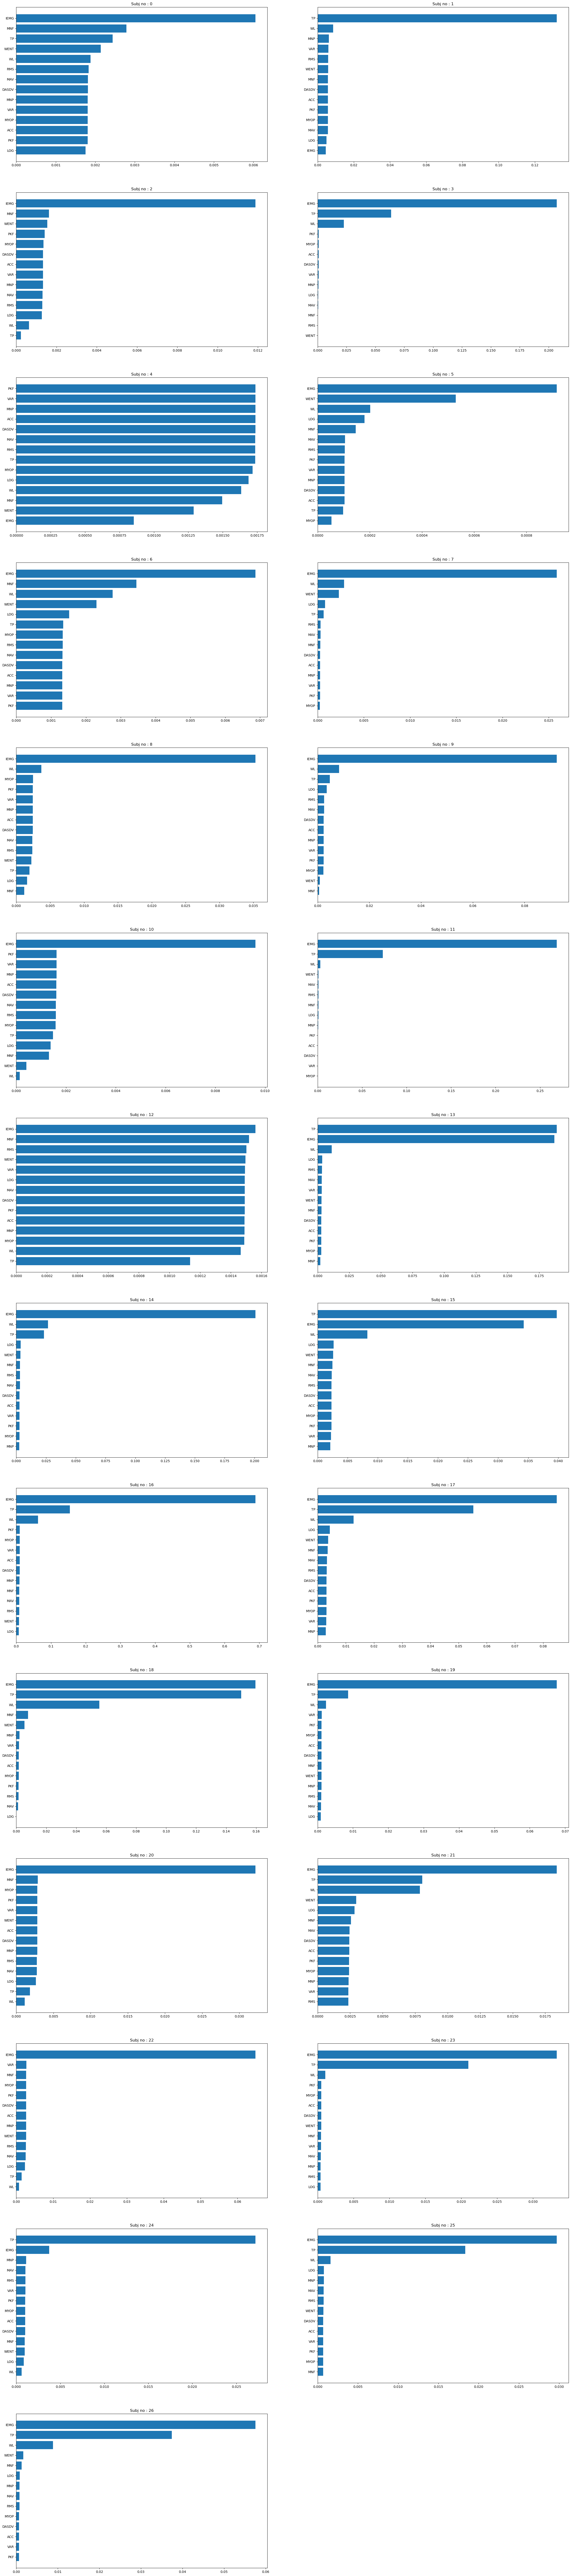

In [125]:
def f_importances(coef, names):
    imp = coef
    # take the absolute value : https://stackoverflow.com/questions/35249760/using-scikit-to-determine-contributions-of-each-feature-to-a-specific-class-pred/49937090#49937090
    imp = np.abs(imp)
    imp,names = zip(*sorted(zip(imp,names)))
    return imp,names

plt.figure(figsize=(30, 10*np.int32(np.ceil(n_subj/2))))
for n in range(n_subj):
        plt.subplot(np.int32(np.ceil(n_subj/2)), 2, n+1)

        imp,names=f_importances(clf[n].coef_[0], feature_names)

        plt.barh(range(len(names)), imp, align='center')
        plt.yticks(range(len(names)), names)

        plt.title("Subj no : %d" %n)


As expected, the distribution and on the covariance matrix : TP, IEMG and WL are the most meaningfull features.

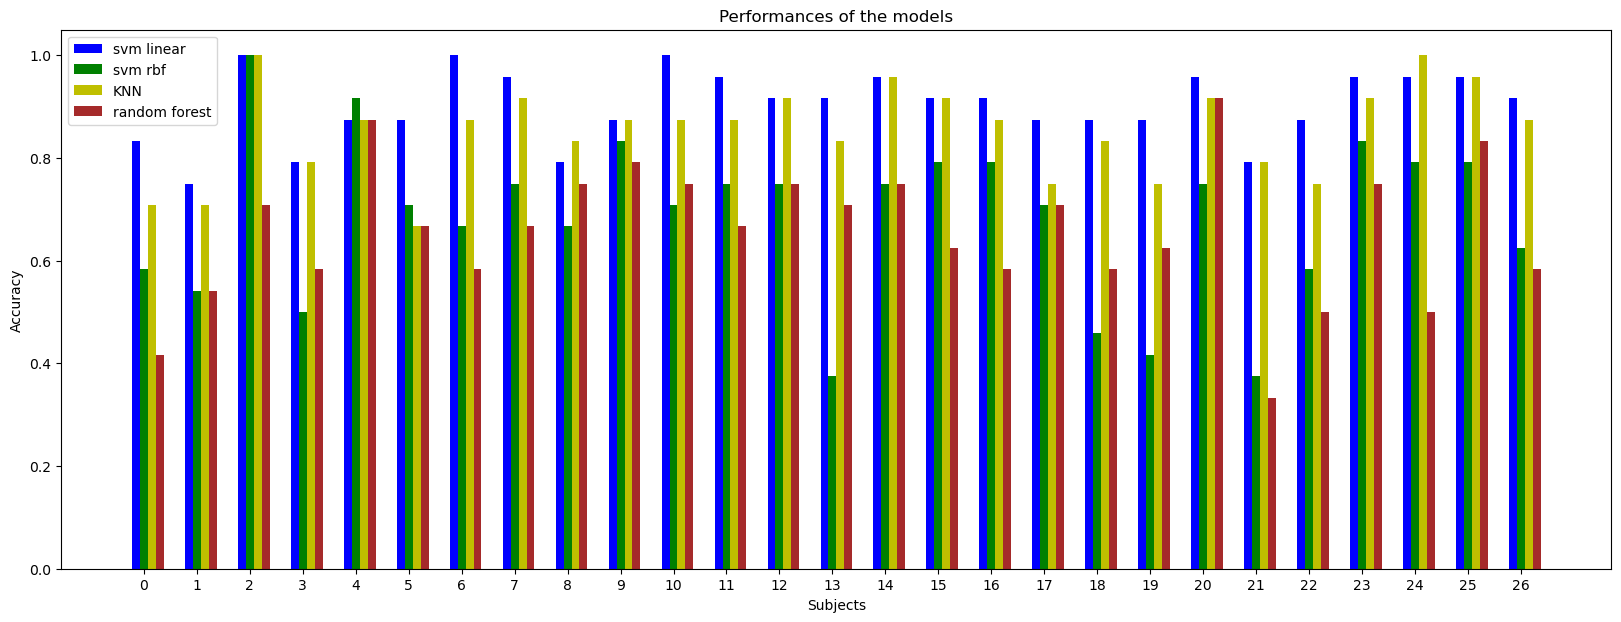

In [126]:
a=np.arange(n_subj)
w=0.15

fig,ax=plt.subplots(figsize=(20,7),edgecolor='k')
p1=ax.bar(a-w, np.array(list(accuracy_svm.values())),w, color='b')
p2=ax.bar(a, np.array(list(accuracy_svm_1.values())),w, color='g')
p3=ax.bar(a+w, np.array(list(accuracy_knn.values())),w, color='y')
p4=ax.bar(a+2*w, np.array(list(accuracy_random.values())),w,color='brown')
ax.set_xticks(a)
ax.set_xticklabels((range(n_subj)))
ax.set_title('Performances of the models')
ax.legend((p1[0],p2[0],p3[0], p4[0]),('svm linear','svm rbf','KNN','random forest'))
plt.xlabel('Subjects')
plt.ylabel('Accuracy')
plt.show()

In [127]:
acc_svm_lin_mean=np.array(list(accuracy_svm.values())).mean()
acc_svm_rbf_mean=np.array(list(accuracy_svm_1.values())).mean()
acc_knn_mean=np.array(list(accuracy_knn.values())).mean()
acc_rand_for_mean=np.array(list(accuracy_random.values())).mean()

In [128]:
print("Mean of SVM accuracy (linear) : %.2g"%acc_svm_lin_mean)
print("Mean of SVM accuracy (rbf) : %.2g"%acc_svm_rbf_mean)
print("Mean of KNN accuracy : %.2g"%acc_knn_mean)
print("Mean of random forest accuracy : %.2g"%acc_rand_for_mean)

Mean of SVM accuracy (linear) : 0.9
Mean of SVM accuracy (rbf) : 0.68
Mean of KNN accuracy : 0.85
Mean of random forest accuracy : 0.66


Here, the SVM with linear kernel is the best model.

# Task 3
**Select couples of subjects that share some feature similarities. Train a classification model on a subject and test it on the other.**

## Finding couples that share feature similarities

We will create a 27 x 27 list of a list, which will give us the norm of the difference vector of each couple.
We will then try to find the indexes (therefore the subjects) of the 10 smallest values in the matrix.

- For each subject we have 12 stimuli x 10 repetitions = 120 mouvements
- For each mouvement we have 14 features x 10 channels = 140

Therefore, print (np.shape (emg_features_norm [0] ) ) = 120 x 140

### 3.1 Correlation between couples

In [129]:
similarities = np.zeros((27,27))

for n in range(n_subj):
    for k in range(n_subj):
        diff = []
        for i in range(n_features):
            diff.append(np.corrcoef(emg_features_norm[n][i], emg_features_norm[k][i])[0,1])
            
        imp_n,_=f_importances(clf[n].coef_[0], feature_names)
        imp_k,_=f_importances(clf[k].coef_[0], feature_names)

        imp_n=list(imp_n)
        imp_k=list(imp_k)
        
        # compute the mean of the weight for the similarities
        imp_mean=np.mean(np.vstack([imp_n, imp_k]), axis=0)
        # take the mean of the correlation of all features, weight them with the importance of the coefficients
        similarities[n][k]= np.average(diff, weights=imp_mean)
            

Text(0.5, 1.0, 'Correlation matrix')

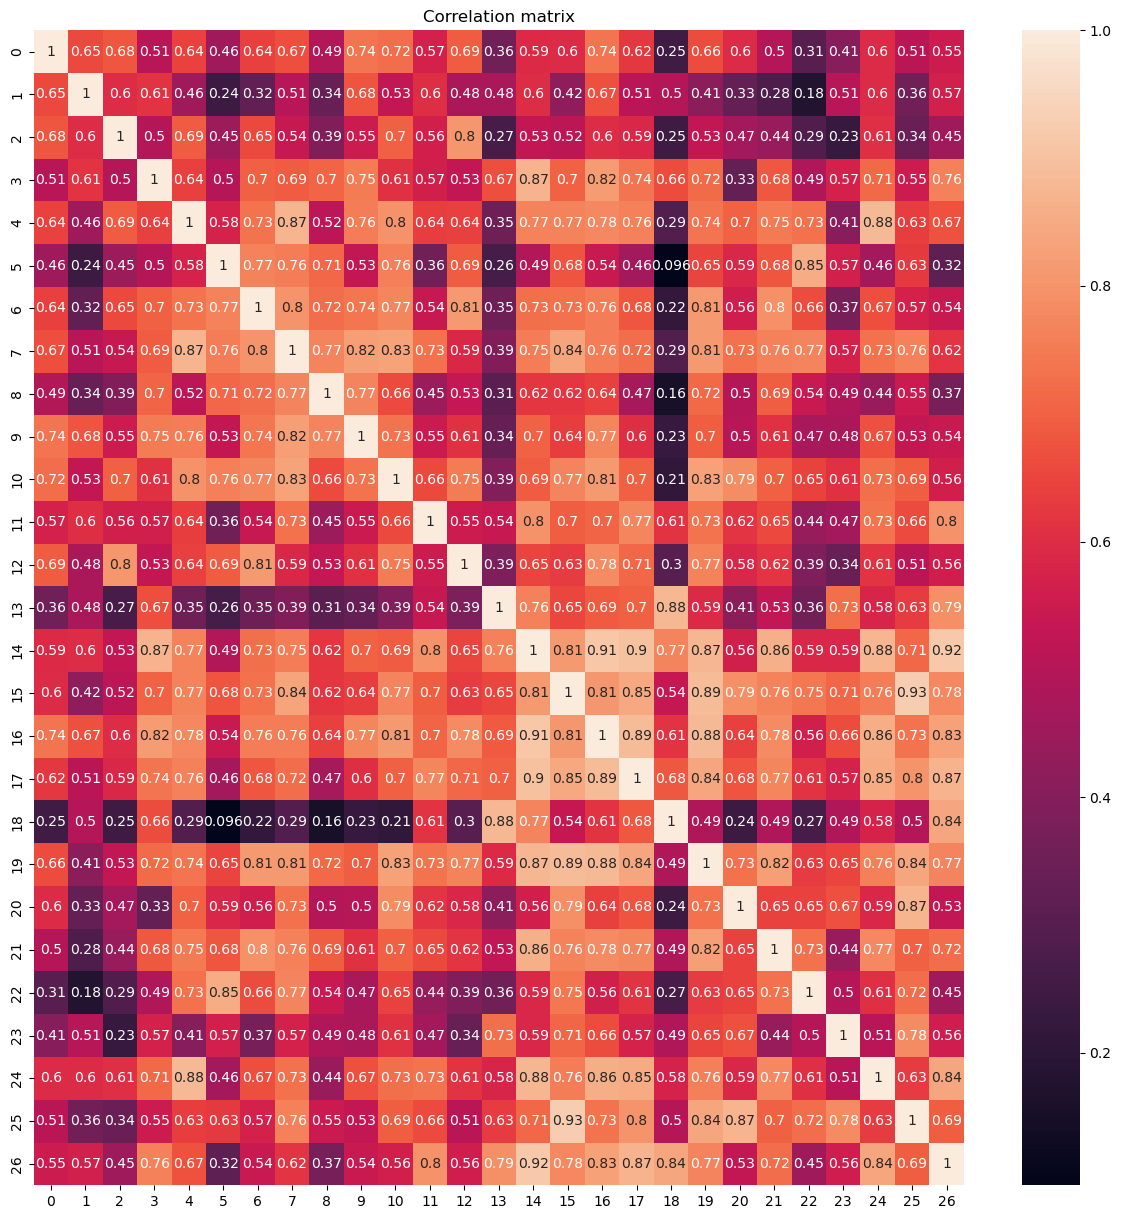

In [130]:
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(data=similarities, ax=ax, annot=True)
plt.title("Correlation matrix")

In [131]:
# remove diagaonals
similarities_find_max = similarities
for i in range(similarities.shape[0]):
    for j in range(similarities.shape[1]):
        if(i==j):
            similarities_find_max[i][j] = 0

# find argmax     
np.unravel_index(similarities_find_max.argmax(), similarities_find_max.shape)

(15, 25)

**We find the following pairs :  $(15, 25) , (4, 7)  , (14, 26)  ,  (14, 3)  ,  (17, 26)$**

### 3.2 Euclidean distance between features of each couple

In [132]:
from scipy.spatial import distance_matrix

In [133]:
D=np.zeros((27, 16800))
for n in range(n_subj):
    D[n]=emg_features_norm[n].flatten().T

dist_mat = distance_matrix(D, D, p=1)
dist_mat = dist_mat/np.max(dist_mat)

Text(0.5, 1.0, 'Euclidean distance matrix, normalized')

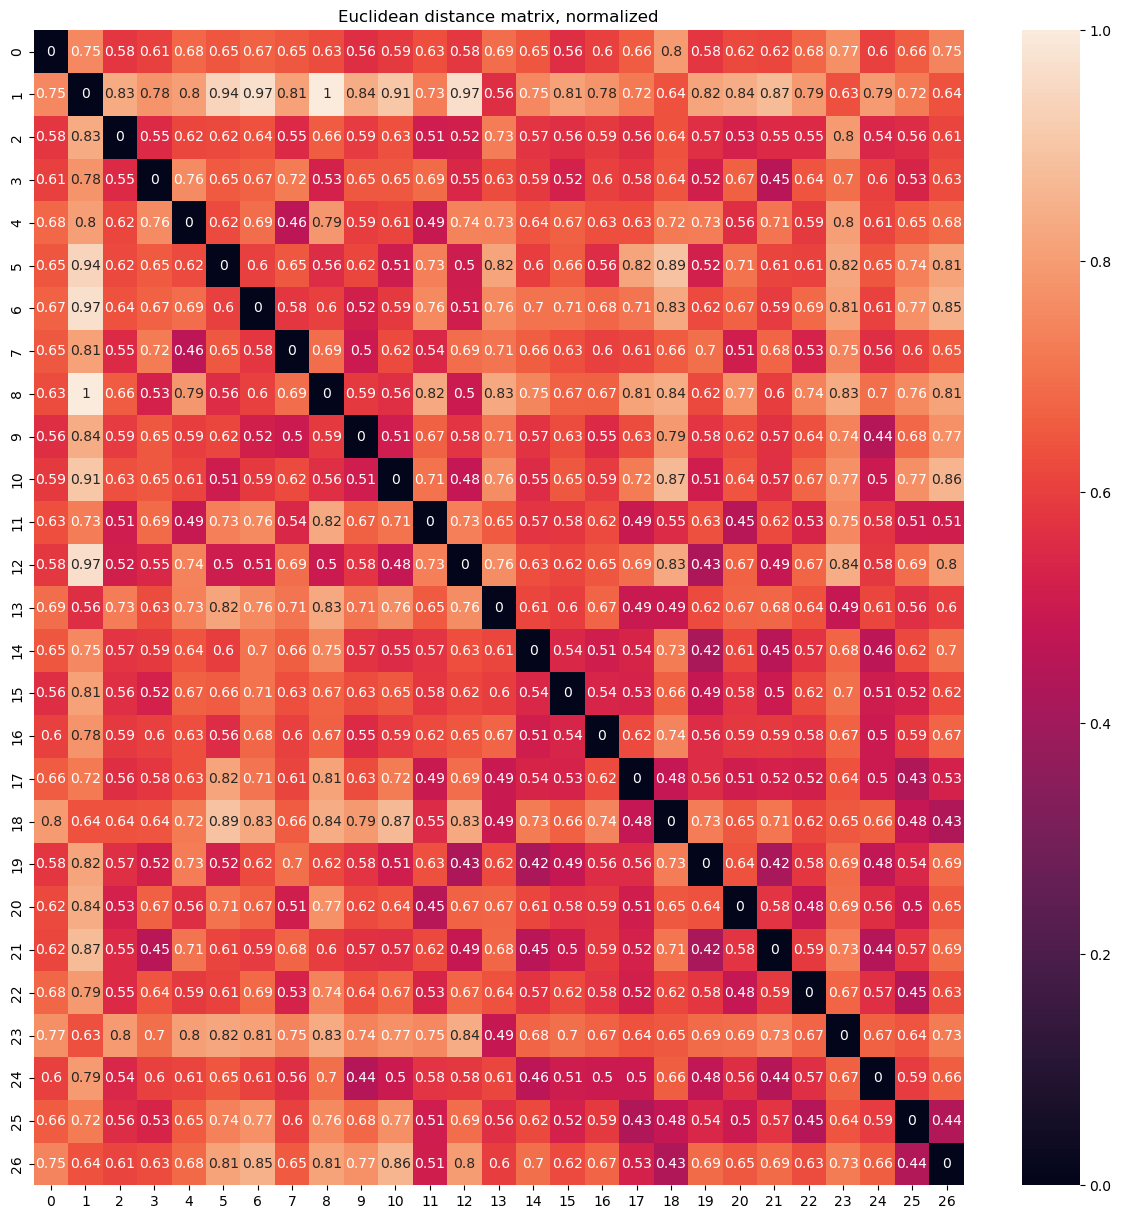

In [134]:
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(data=dist_mat, ax=ax, annot=True)
plt.title("Euclidean distance matrix, normalized")

In [135]:
# Initialize a list to keep track of the 10 smallest values and their indexes
min_values = []
# remove diagaonals
similarities_find_max = dist_mat
for i in range(similarities_find_max.shape[0]):
    for j in range(similarities_find_max.shape[1]):
        if(i==j):
            similarities_find_max[i][j] = 100

# Iterate over the rows and columns of the table
for i in range(len(similarities_find_max)):
    for j in range(len(similarities_find_max[i])):
        # Add the current value and its indexes to the list
        min_values.append((similarities_find_max[i][j], (i, j)))
        
        # Sort the list in ascending order based on the values
        min_values = sorted(min_values, key=lambda x: x[0])
        
        # If the list has more than 10 elements, remove the last element
        if len(min_values) > 10:
            min_values.pop()

# Print the 10 pairs of indexes with the minimum value
print(min_values[:10])

[(0.41564830815467213, (19, 21)), (0.41564830815467213, (21, 19)), (0.42405654626431155, (14, 19)), (0.42405654626431155, (19, 14)), (0.4267154291363212, (12, 19)), (0.4267154291363212, (19, 12)), (0.4312254518455128, (17, 25)), (0.4312254518455128, (25, 17)), (0.43490034000833505, (18, 26)), (0.43490034000833505, (26, 18))]


With this metric we have to minimize the distance between the mean of the features of each subject. Then we seek for the minimum.     
**We find the following pairs :  $(19, 21), (14, 19)  , (12, 19), (17, 25),  (26, 18)$**

In [136]:
from sklearn.metrics.pairwise import cosine_similarity

In [137]:
C=np.zeros((27, 16800))
for n in range(n_subj):
    C[n]=emg_features_norm[n].flatten().T

cos_mat = cosine_similarity(C, C)
#cos_mat = dist_mat/np.max(dist_mat)

Text(0.5, 1.0, 'Cosine matrix')

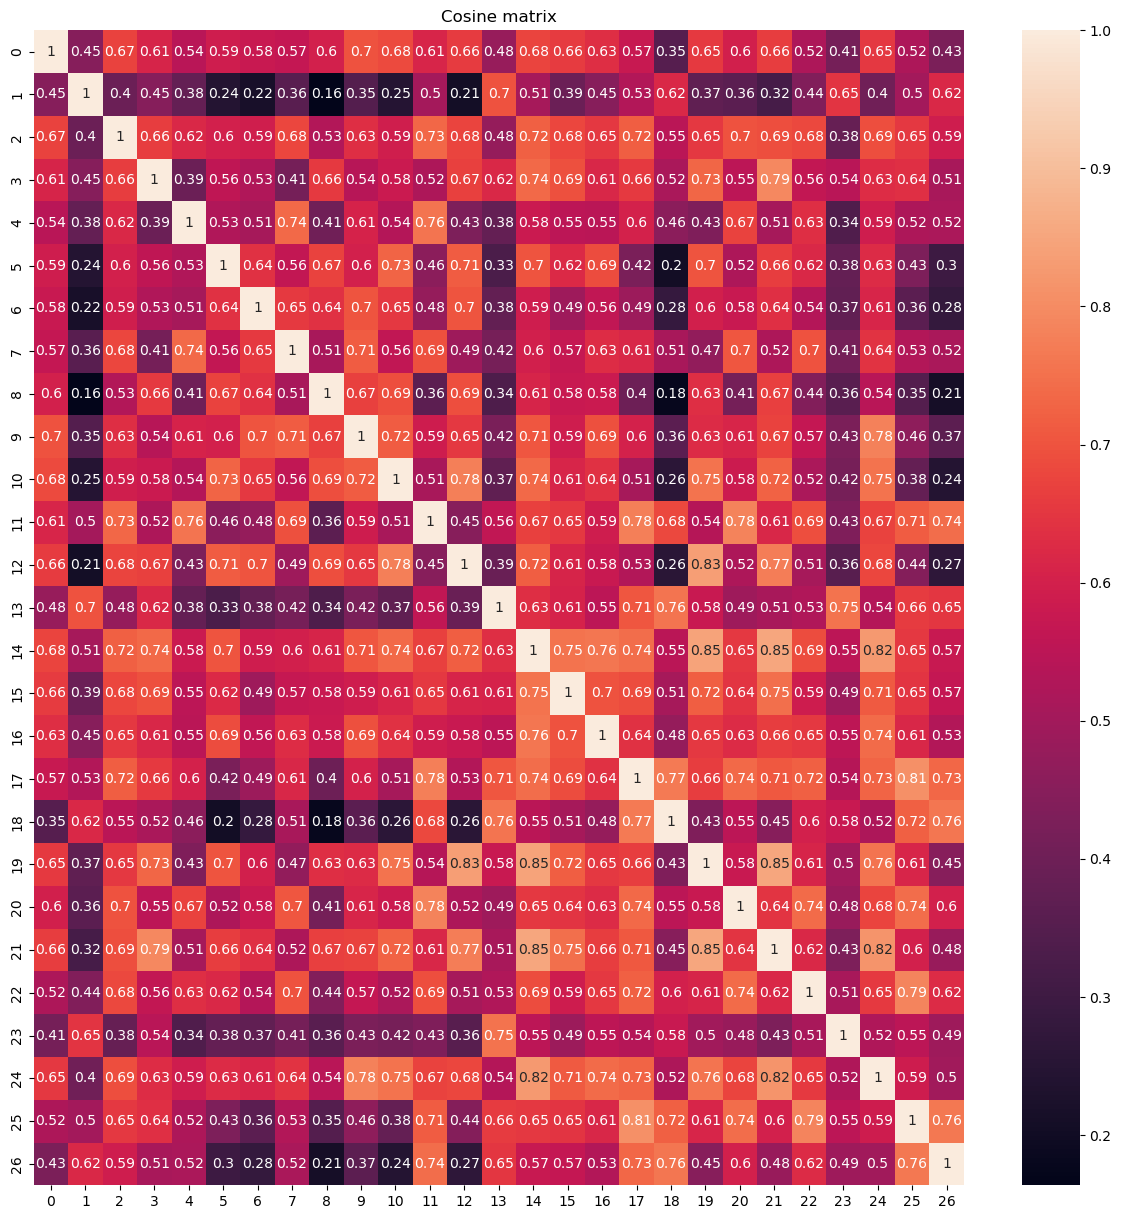

In [138]:

fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(data=cos_mat, ax=ax, annot=True)
plt.title("Cosine matrix")

### Aglomerative clustering, dendrogram plot

In [139]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

In [140]:
X=np.zeros((27, 16800))
for n in range(n_subj):
    X[n]=emg_features_norm[n].flatten().T

In [141]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


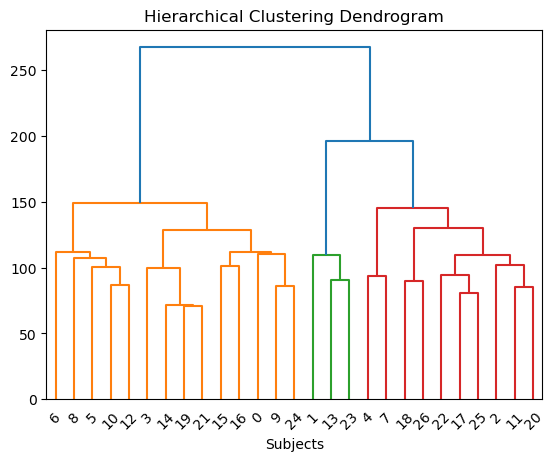

In [142]:
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(X)
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=7)
plt.xlabel("Subjects")
plt.show()

The dendrogram is the most meaningfull of all the last plot. It give us information about the clusters, not only about the correlated pairs.

### Training on the first subject of a pair and testing on the other

In [143]:
pairs = [(4, 7),  (17, 25), (19,21), (14, 21), (14, 19), (9, 24), (12, 10), (6, 20)]


X_train={}
X_test={}
y_train={}
y_test={}
for i, p in enumerate(pairs):
    # X features, y labels
    X_train[i], y_train[i] = emg_features_norm[p[0]], labels_dict[p[0]]
    X_test[i], y_test[i] = emg_features_norm[p[1]], labels_dict[p[1]]

In [144]:
from sklearn.metrics import accuracy_score

### SVM Model

In [145]:
clf={}
for i in range(len(pairs)):
    clf[i] = svm.SVC(kernel='linear', verbose=True)
    clf[i].fit(X_train[i], y_train[i])
    

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

In [146]:
y_hat={}
error={}
accuracy_svm={}

for i in range(len(pairs)):
    accuracy_svm[i] = accuracy_score(y_test[i], clf[i].predict(X_test[i]))
    print("Accuracy of the SVM model trained on subject {0:d} and tested on subject {1:d}: {2:.2f}".format(pairs[i][0],pairs[i][1],accuracy_svm[i]))

Accuracy of the SVM model trained on subject 4 and tested on subject 7: 0.46
Accuracy of the SVM model trained on subject 17 and tested on subject 25: 0.35
Accuracy of the SVM model trained on subject 19 and tested on subject 21: 0.17
Accuracy of the SVM model trained on subject 14 and tested on subject 21: 0.25
Accuracy of the SVM model trained on subject 14 and tested on subject 19: 0.34
Accuracy of the SVM model trained on subject 9 and tested on subject 24: 0.28
Accuracy of the SVM model trained on subject 12 and tested on subject 10: 0.15
Accuracy of the SVM model trained on subject 6 and tested on subject 20: 0.17


In [147]:
clf_2={}
for i in range(len(pairs)):
    clf_2[i] = svm.SVC(kernel='rbf', verbose=True)
    clf_2[i].fit(X_train[i], y_train[i])

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

In [148]:
y_hat={}
error={}
accuracy_svm_2={}

for i in range(len(pairs)):
    accuracy_svm_2[i] = accuracy_score(y_test[i], clf_2[i].predict(X_test[i]))
    print("Accuracy of the SVM model trained on subject {0:d} and tested on subject {1:d}: {2:.2f}".format(pairs[i][0],pairs[i][1],accuracy_svm_2[i]))

Accuracy of the SVM model trained on subject 4 and tested on subject 7: 0.34
Accuracy of the SVM model trained on subject 17 and tested on subject 25: 0.41
Accuracy of the SVM model trained on subject 19 and tested on subject 21: 0.19
Accuracy of the SVM model trained on subject 14 and tested on subject 21: 0.32
Accuracy of the SVM model trained on subject 14 and tested on subject 19: 0.29
Accuracy of the SVM model trained on subject 9 and tested on subject 24: 0.30
Accuracy of the SVM model trained on subject 12 and tested on subject 10: 0.33
Accuracy of the SVM model trained on subject 6 and tested on subject 20: 0.20


### KNN Model

In [149]:
knn_model={}
for i in range(len(pairs)):
    knn_model[i] = KNeighborsClassifier(3)
    knn_model[i].fit(X_train[i], y_train[i])

In [150]:
y_hat={}
error={}
accuracy_knn={}

for i in range(len(pairs)):
    accuracy_knn[i] = accuracy_score(y_test[i], knn_model[i].predict(X_test[i]))
    print("Accuracy of the KNN model trained on subject {0:d} and tested on subject {1:d}: {2:.2f}".format(pairs[i][0],pairs[i][1],accuracy_knn[i]))

Accuracy of the KNN model trained on subject 4 and tested on subject 7: 0.39
Accuracy of the KNN model trained on subject 17 and tested on subject 25: 0.38
Accuracy of the KNN model trained on subject 19 and tested on subject 21: 0.21
Accuracy of the KNN model trained on subject 14 and tested on subject 21: 0.28
Accuracy of the KNN model trained on subject 14 and tested on subject 19: 0.30
Accuracy of the KNN model trained on subject 9 and tested on subject 24: 0.38
Accuracy of the KNN model trained on subject 12 and tested on subject 10: 0.19
Accuracy of the KNN model trained on subject 6 and tested on subject 20: 0.18


### Random Forest Model

In [151]:
randomForest_model={}

for i in range(len(pairs)):
    randomForest_model[i] = RandomForestClassifier(max_depth=2, random_state=0)
    randomForest_model[i].fit(X_train[i], y_train[i])


In [152]:
y_hat={}
error={}
accuracaccuracy_rand_for={}

for i in range(len(pairs)):
    accuracaccuracy_rand_for[i] = accuracy_score(y_test[i], randomForest_model[i].predict(X_test[i]))
    print("Accuracy of the KNN model trained on subject {0:d} and tested on subject {1:d}: {2:.2f}".format(pairs[i][0],pairs[i][1],accuracaccuracy_rand_for[i]))

Accuracy of the KNN model trained on subject 4 and tested on subject 7: 0.38
Accuracy of the KNN model trained on subject 17 and tested on subject 25: 0.22
Accuracy of the KNN model trained on subject 19 and tested on subject 21: 0.12
Accuracy of the KNN model trained on subject 14 and tested on subject 21: 0.12
Accuracy of the KNN model trained on subject 14 and tested on subject 19: 0.21
Accuracy of the KNN model trained on subject 9 and tested on subject 24: 0.38
Accuracy of the KNN model trained on subject 12 and tested on subject 10: 0.12
Accuracy of the KNN model trained on subject 6 and tested on subject 20: 0.18


In [153]:
acc_svm_lin_mean=np.array(list(accuracy_svm.values())).mean()
acc_svm_rbf_mean=np.array(list(accuracy_svm_2.values())).mean()
acc_knn_mean=np.array(list(accuracy_knn.values())).mean()
acc_rand_for_mean=np.array(list(accuracaccuracy_rand_for.values())).mean()

In [154]:
print("Mean of SVM accuracy (linear) : %.2g"%acc_svm_lin_mean)
print("Mean of SVM accuracy (rbf) : %.2g"%acc_svm_rbf_mean)
print("Mean of KNN accuracy : %.2g"%acc_knn_mean)
print("Mean of random forest accuracy : %.2g"%acc_rand_for_mean)

Mean of SVM accuracy (linear) : 0.27
Mean of SVM accuracy (rbf) : 0.3
Mean of KNN accuracy : 0.29
Mean of random forest accuracy : 0.21


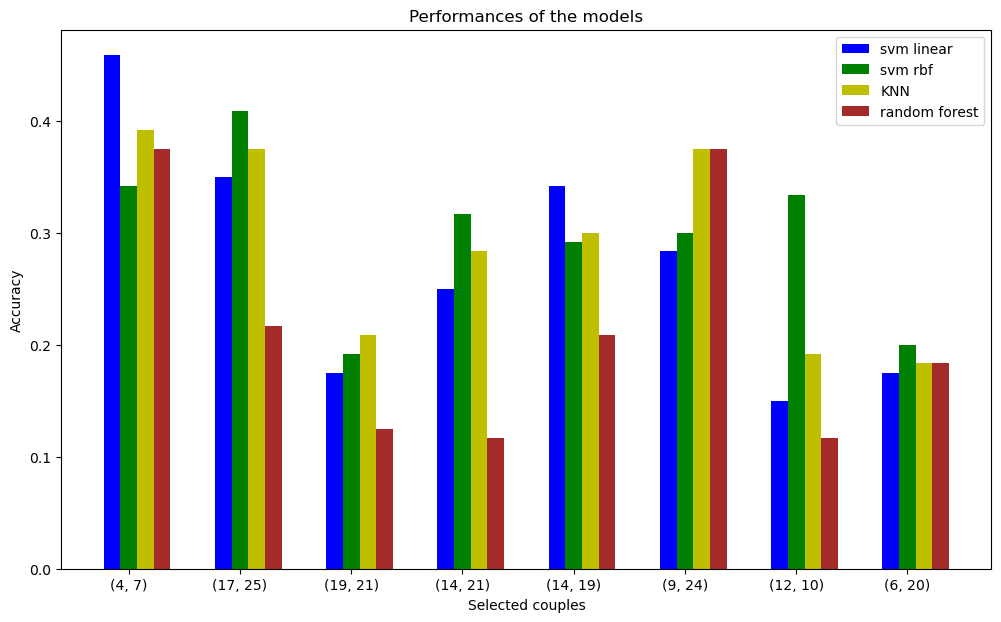

In [155]:
a=np.arange(8)
w=0.15

fig,ax=plt.subplots(figsize=(12,7),edgecolor='k')
p1=ax.bar(a-w, np.array(list(accuracy_svm.values())),w, color='b')
p2=ax.bar(a, np.array(list(accuracy_svm_2.values())),w, color='g')
p3=ax.bar(a+w, np.array(list(accuracy_knn.values())),w, color='y')
p4=ax.bar(a+2*w, np.array(list(accuracaccuracy_rand_for.values())),w,color='brown')
ax.set_xticks(a)
ax.set_xticklabels((pairs))
ax.set_title('Performances of the models')
ax.legend((p1[0],p2[0],p3[0], p4[0]),('svm linear','svm rbf','KNN','random forest'))
plt.xlabel('Selected couples')
plt.ylabel('Accuracy')
plt.show()

For this task, the best model is the SVM with rbf kernel. Results are close with the KNN and the SVM (linear) models.      
The couple (4,7) seems to be very correlated since the SVM (lin) have been able to predict approximaletly the half of the right classes.

### Compute Similarities 

Similarities are defined as : 
- Accuracy obtained by training on subject i and testing on subject j
- Accuracy obtained by training on subject j and testing on subject i
- Then taking the average of the both

Here we compute the similarities to have an idea of the closeness of each pairs, using the previous model with the best results.


In [156]:
from itertools import permutations, product

In [157]:
# initialize N 
N = 2
  
# All possible N combination tuples
# Using product()
res = list(product(range(n_subj), repeat = N))

index=[]
for i in range(len(res)):
    res[i]=sorted(res[i])
    if(res[i][0]==res[i][1]):
        index.append(i)

pairs = np.delete(res, index, axis=0)

def removeDuplicates(lst):
    return [t for t in (set(tuple(i) for i in lst))]

pairs_dict={}         
pairs_dict[0] = sorted(removeDuplicates(pairs))
pairs_dict[1]=[]
for i in range(len(pairs_dict[0])):
    pairs_dict[1].append(pairs_dict[0][i][::-1])



In [158]:
X_train={}
X_test={}
y_train={}
y_test={}

X_train[0]={}
X_test[0]={}
y_train[0]={}
y_test[0]={}
for i, p in enumerate(pairs_dict[0]):
    # X features, y labels
    X_train[0][i], y_train[0][i] = emg_features_norm[p[0]], labels_dict[p[0]]
    X_test[0][i], y_test[0][i] = emg_features_norm[p[1]], labels_dict[p[1]]

X_train[1]={}
X_test[1]={}
y_train[1]={}
y_test[1]={}
for i, p in enumerate(pairs_dict[1]):
    # X features, y labels
    X_train[1][i], y_train[1][i] = emg_features_norm[p[0]], labels_dict[p[0]]
    X_test[1][i], y_test[1][i] = emg_features_norm[p[1]], labels_dict[p[1]]

In [159]:
clf={}

clf[0]={}
for i in range(len(pairs_dict[0])):
    clf[0][i] = svm.SVC(kernel='rbf', verbose=True)
    clf[0][i].fit(X_train[0][i], y_train[0][i])

clf[1]={}
for i in range(len(pairs_dict[1])):
    clf[1][i] = svm.SVC(kernel='rbf', verbose=True)
    clf[1][i].fit(X_train[1][i], y_train[1][i])

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

In [160]:
acc_0=np.zeros(len(pairs_dict[0]))
acc_1=np.zeros(len(pairs_dict[1]))
similarity=np.zeros(len(pairs_dict[1]))

for i in range(len(pairs_dict[0])):
    acc_0[i] = accuracy_score(y_test[0][i], clf[0][i].predict(X_test[0][i]))
    acc_1[i] = accuracy_score(y_test[1][i], clf[1][i].predict(X_test[1][i]))
    similarity[i] = (acc_0[i]+acc_1[i])/2

In [161]:
similarity_mat = np.zeros((n_subj, n_subj))
for i, tup in enumerate(pairs_dict[0]):
    similarity_mat[tup[0], tup[1]]=similarity[i]

Text(0.5, 1.0, 'Similarity matrix')

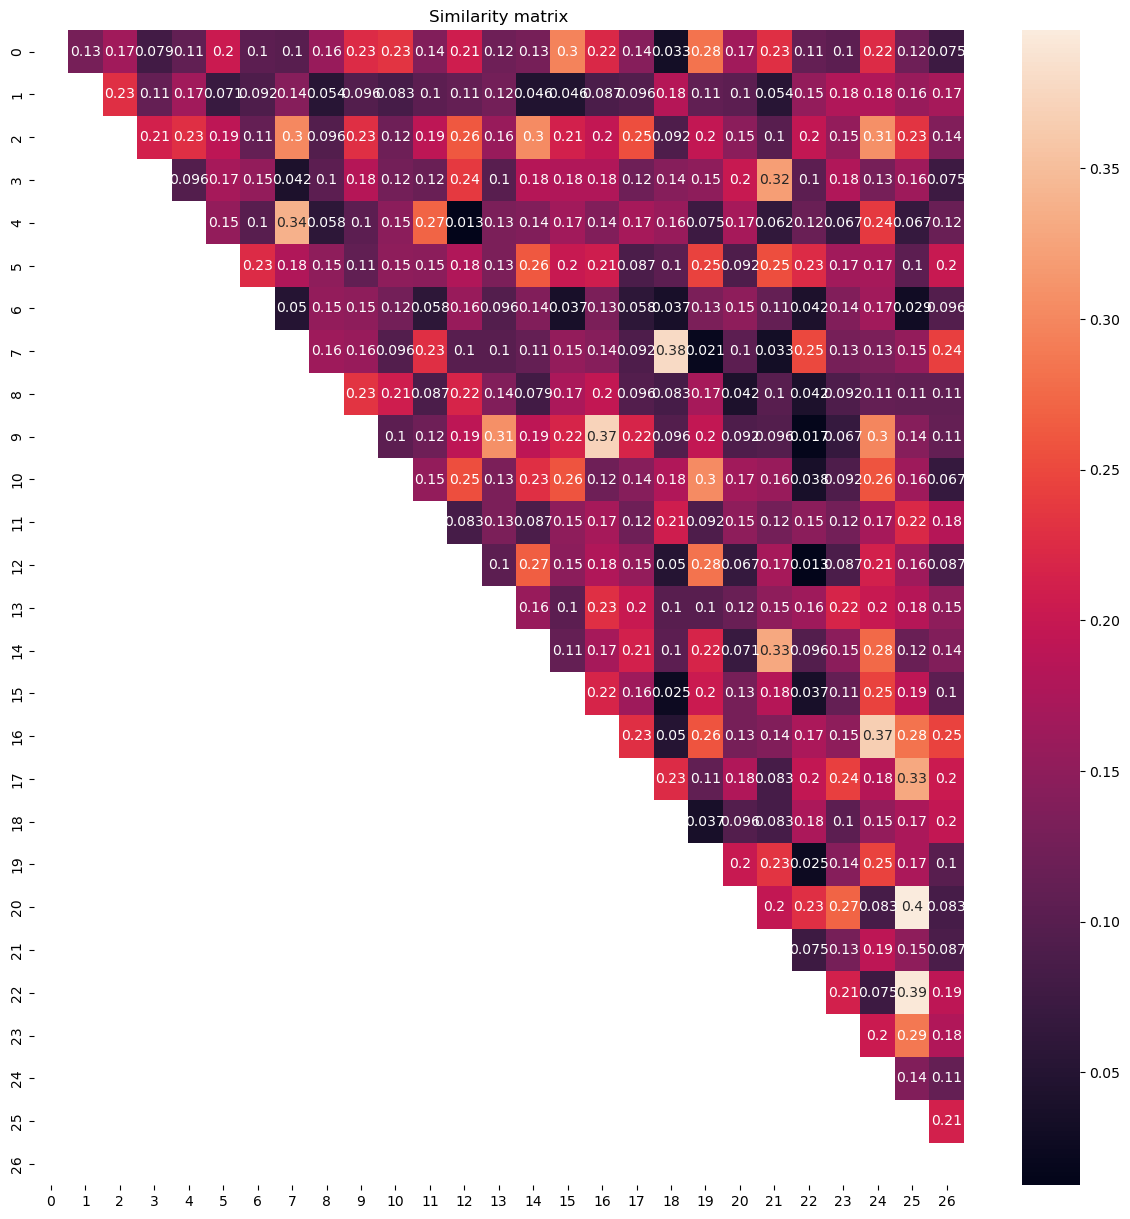

In [162]:
up_triang = np.tril(np.ones_like(similarity_mat)).astype(bool)


fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(data=similarity_mat, ax=ax, annot=True, mask=up_triang)
plt.title("Similarity matrix")

The couple (4, 7) is the most similare using this metric. The other features which should be very correlated like (26, 14) or (19, 14) are very different using this metric.     
**It means that our models found information and patterns about classes to predict in the features that we had not found using our metrics.**

# Task 4
**Train a classification model on a set of subjects and test it on a subject not belonging to the set. Do the same thing varying the number of subjects in the training set and discuss the classification performance.**

In [163]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from matplotlib import cm as CM
import numpy as NP
from matplotlib import pyplot as PLT

In [164]:
for n in range(n_subj):
    # X features, y labels
    X_train[n], X_test[n], y_train[n], y_test[n] = train_test_split(emg_features_norm[n], labels_dict[n], test_size=0.2)

## Plot of best accuracy for a test subject for a given number of training subjects

0.29166666666666663

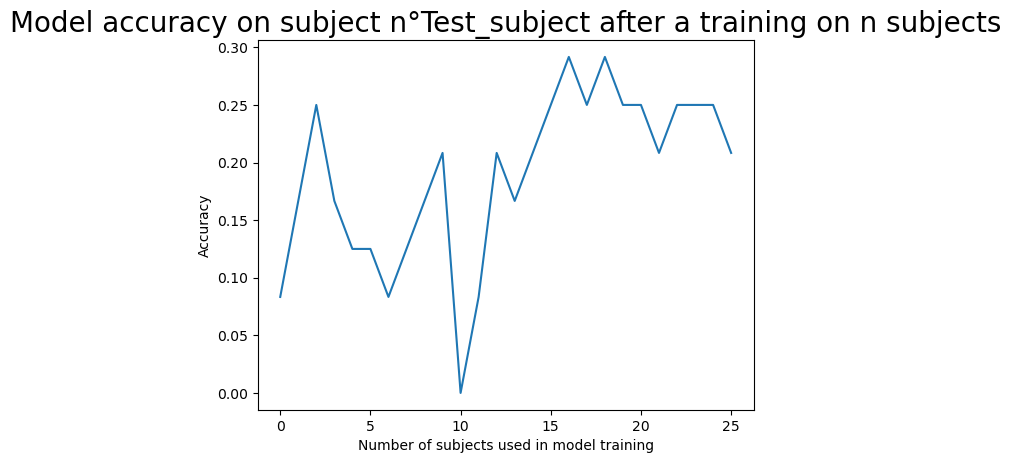

In [165]:
Test_subject = 10
clf = svm.SVC(kernel='linear', verbose=False)

top_accuracies = []

if (Test_subject) != 0:
    X_training = X_train[0]
    Y_training = y_train[0]
else :
    X_training = X_train[1]
    Y_training = y_train[1]

for x in range(26): 
    top_accuracy = 0
    if (Test_subject) != x:
        X_training= np.append(X_training, X_train[x], axis = 0)
        Y_training= np.append(Y_training, y_train[x], axis = 0)

        clf.fit(X_training, Y_training)
        y_hat=clf.predict(X_test[Test_subject])
        error = len(np.where((y_hat-y_test[Test_subject])!=0)[0])
        accuracy_svm = 1-(error/len(y_hat))
        
        if accuracy_svm > top_accuracy :
            top_accuracy = accuracy_svm
    top_accuracies.append(top_accuracy)
plt.title('Model accuracy on subject n°Test_subject after a training on n subjects', fontsize = 20)
plt.xlabel('Number of subjects used in model training')
plt.ylabel('Accuracy')
plt.plot(top_accuracies)
max(top_accuracies)

A linear SVM model is tested on subject n°Test_subject after being trained on subject 1, 1 and 2, 1,2 and 3, etc... The addition of more data make the model more accurrate but still settles for a suboptimal value

## Accuracies when testing the model on subject n after training the model with subject x et y

In [166]:
@interact(n=(0,26))
def g(n):
    clf = svm.SVC(kernel='linear', verbose=False)
    accuracy_matrix = np.zeros((27,27))
    labels = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24, 25, 26]

    X_training2 = np.zeros((192, 140))
    Y_training2 = np.zeros((1, 192))

    for x in range(27):
        accuracies = []
        for y in range(27):
            X_training2= np.append(X_train[x], X_train[y], axis = 0)
            Y_training2= np.append(y_train[x], y_train[y], axis = 0)

            clf.fit(X_training2, Y_training2)
            y_hat=clf.predict(X_test[n])
            error = len(np.where((y_hat-y_test[n])!=0)[0])
            accuracy_svm = 1-(error/len(y_hat))
            accuracy_matrix[x][y]= accuracy_svm
            
    accuracy_matrix = accuracy_matrix- np.eye(27)*accuracy_matrix
    up_triang = np.triu(np.ones_like(accuracy_matrix)).astype(bool) 
    
    fig, ax = plt.subplots(figsize=(15, 15))
    plt.title('Model accuracy on test subject n after a training on couples of subjects (x,y)', fontsize = 20) # title with fontsize 20
    
    sns.heatmap(data=accuracy_matrix, ax=ax, annot=True, mask=up_triang, xticklabels = labels,yticklabels = labels, fmt=".2f" )
    

interactive(children=(IntSlider(value=13, description='n', max=26), Output()), _dom_classes=('widget-interact'…

This matrix represent all the possible combinations of couples of subjects dataset for the model training.
The axis x and y represent the number of the subject, the value in each case the accuracy of the model for the given training when tested on subject n. It is the first step of the optimization of the training as it gives us the best training couple for a subject

## Implementation of an algorithm to get the best model training for a given test subject

The best training subject combination is [[8, 23], 0.45833333333333337]


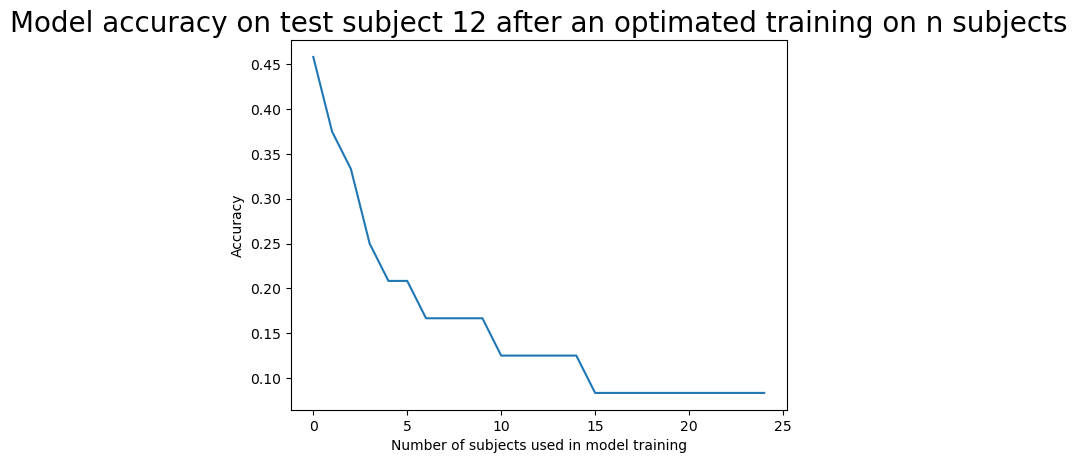

In [167]:
Test_subject = 10
clf = svm.SVC(kernel='linear', verbose=False)

best_training_sequence = []
top_accuracies = []

#best two first datasets
accuracy_matrix = np.zeros((27,27))
top_accuracy = 0
a = 0
b = 0
for x in range(27):
    for y in range(27):
        if x != y :
            X_training= np.append(X_train[x], X_train[y], axis = 0)
            Y_training= np.append(y_train[x], y_train[y], axis = 0)

            clf.fit(X_training, Y_training)
            y_hat=clf.predict(X_test[Test_subject])
            error = len(np.where((y_hat-y_test[Test_subject])!=0)[0])
            accuracy_svm = 1-(error/len(y_hat))
        
            if (x != Test_subject) and (y != Test_subject) :
                if accuracy_svm > top_accuracy :
                    top_accuracy = accuracy_svm
                    a = x
                    b = y
                
top_accuracies.append(top_accuracy)
best_training_sequence.append(a)
best_training_sequence.append(b)
X_best_training = np.append(X_train[a], X_train[b], axis = 0)
Y_best_training = np.append(y_train[a], y_train[b], axis = 0)
    
#best next dataset
for z in range(24):
    next_best = -1
    top_accuracy = 0
    for x in range(27):
        if ((x) not in best_training_sequence) and (x != Test_subject)  :
            X_training= np.append(X_best_training, X_train[x], axis = 0)
            Y_training= np.append(Y_best_training, y_train[x], axis = 0)
        
            clf.fit(X_training, Y_training)
            y_hat=clf.predict(X_test[Test_subject])
            error = len(np.where((y_hat-y_test[Test_subject])!=0)[0])
            accuracy_svm = 1-(error/len(y_hat))
        
            if accuracy_svm > top_accuracy :
                top_accuracy = accuracy_svm
                next_best = x
    if next_best != -1:
        top_accuracies.append(top_accuracy)
        best_training_sequence.append(next_best)
        X_best_training = np.append(X_best_training, X_train[x], axis = 0)
        Y_best_training = np.append(Y_best_training, y_train[x], axis = 0)

#creating interestiing results        
datas = [[best_training_sequence[0],best_training_sequence[1]],top_accuracies[0]]
for x in range(22):
    datas.append([best_training_sequence[x+2],top_accuracies[x+1]])
result = datas[:top_accuracies.index(max(top_accuracies))+2]
plt.title('Model accuracy on test subject 12 after an optimated training on n subjects', fontsize = 20)
plt.xlabel('Number of subjects used in model training')
plt.ylabel('Accuracy')
plt.plot(top_accuracies)
print("The best training subject combination is", result)

Each added subject to the training of the model was selected because it was the remaining subject giving the biggest accuracy. We can see that when we select the subject used in the training as well as their order, we can obtain far better results in terms of accuracy.